# $\chi^2$ Investigations

In this notebook we first investigate how the `absolute_simga` parameter of `curve_fit` can affect the inferred uncertainty on the data.

To this end, we simulate many dataset using a normal distribution:

$$ y\sim \mathcal{N}(\mu, \sigma_y)$$

With $\mu$ the true position as given by our model and $\sigma_y$ the uncertainty (standard error) of the data $y$.

First we define our model:

In [3]:
# basic imports
import scipy.stats
from scipy.optimize import curve_fit
from pylab import * #l

# let's define our model
np.random.seed(10) # fix seed to compare results

# we fix the true values of the parameters
a_true = 2
b_true = 3
c_true = 4

# we fix the range of of the independent variable (say, time)
xmin = 0.1
xmax = 10

def linear_model(x, a, b):
	'''
	a line
	'''
	return a + x*b

This function simulates data. We may assume that the uncertainty on $y$ is a fixed fraction of the true value.

In [4]:
def sim_data(x, fractional_uncertainty=0.2):

	# find the model prediction
	y_true = model(x, a_true, b_true)

	# find the true uncertainty on the observations
	y_unc_true = np.abs(y_true)*fractional_uncertainty

	# generate data for a normal distribution
	y_sample = np.random.normal(y_true, y_unc_true, size=len(x))

	return y_sample, y_unc_true


_the cell below allows you to toggle between models (these will be added later)_

In [13]:
# lets pick one model
model = linear_model
#model = non_linear_model # you might add this later



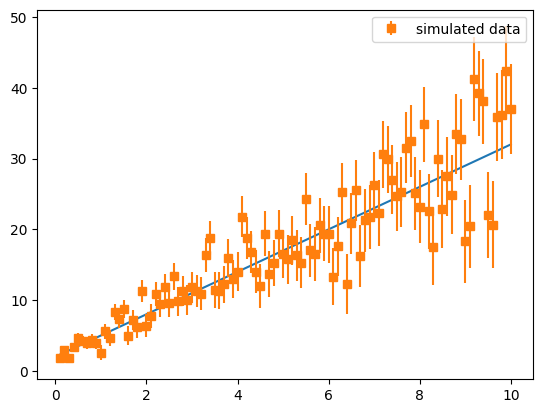

if you think this looks weird, it helps to look in log-space


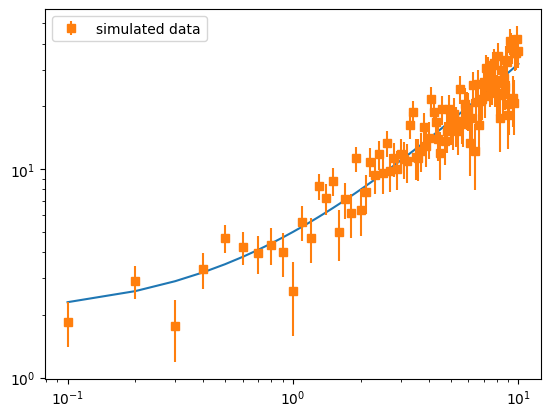

In [14]:
# plot the simulation results
xx = np.linspace(xmin, xmax, 100)
data_example = sim_data(xx)

plt.clf()
plt.plot(xx, model(xx, a_true, b_true))
plt.errorbar(xx, data_example[0],data_example[1], fmt='s', label='simulated data')
plt.legend()
plt.pause(0.1)
print('if you think this looks weird, it helps to look in log-space')

plt.clf()
plt.plot(xx, model(xx, a_true, b_true))
plt.errorbar(xx, data_example[0],data_example[1], fmt='s', label='simulated data')
plt.legend()
plt.yscale('log')
plt.xscale('log')

## Part 1: $\chi^2$ rescaling of `curve_fit`

Make 5000 simulation of a dataset with N=3 points. Of each simulation, find the standard error on the slope ($\sigma_{b}$) of the best-fit line using `curve_fit` with `absolute_sigma=False` (the default). In this setting the uncertainties are rescaled using the $\chi^2$ of the best-fit parameters.

- Plot a distribution of the 5000 $\chi^2$ and compare to the theoretical value (see `scipy.stats.chi2`).

- Compare the distribution of $\sigma_{b}$ with the "correct" value. How often is confidence interval with $\chi^2$-rescaling a factor 2 larger compared to the correct value?

- Repeat the last step with $N=10$ datapoints.

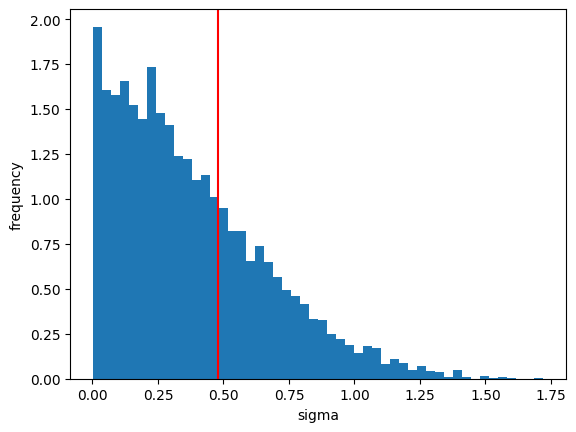

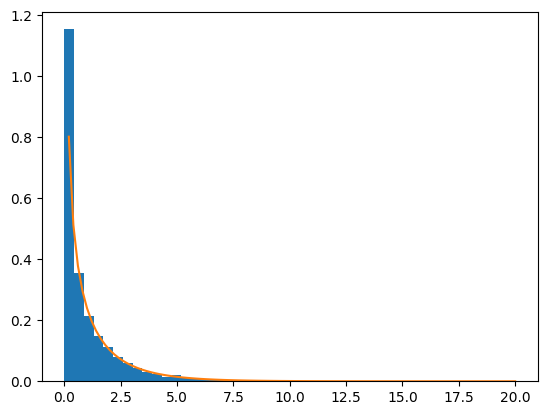

In [6]:
def non_linear_model(x, a, b, c):
    return a + x*b + (x**2)*c


def linear_model(x, a, b):
	return a + x*b

def sim_data(x, fractional_uncertainty=0.2):

	# find the model prediction
	y_true = model(x, a_true, b_true)

	# find the true uncertainty on the observations
	y_unc_true = np.abs(y_true)*fractional_uncertainty

	# generate data for a normal distribution
	y_sample = np.random.normal(y_true, y_unc_true, size=len(x))

	return y_sample, y_unc_true

model = linear_model
sigmas_b = []
chi_2_loop = []
#model = non_linear_model # you might add this later
for i in range(0,5000):
    # plot the simulation results
    x_data = np.linspace(xmin, xmax, 3)
    y_data, sigma_y = sim_data(x_data)
    
    popt, pcov = curve_fit(linear_model, x_data, y_data, sigma = sigma_y)
    _, pcov_true = curve_fit(linear_model, x_data, y_data, sigma = sigma_y, absolute_sigma=True)
    true_sigma = pcov_true[1,1] #we do [1,1] to get only the sigma_b 
    true_sigma = np.sqrt(true_sigma)

    sigma_b = np.sqrt(np.diag(pcov))[1] #this is the same as above to get the sigma_1 out of a 4x4 matrix. 
    sigmas_b.append(sigma_b)
    

    chi_2_loop.append(np.sum(((y_data - model(x_data, *popt))/sigma_y)**2))


plt.hist(sigmas_b, bins = 50, density=True)
plt.axvline(true_sigma, c='r')
plt.xlabel("sigma")
plt.ylabel("frequency") 
plt.show()

x_value = np.linspace(0, 20, 100)
chi_2 = scipy.stats.chi2.pdf(x_value, 1) 
plt.hist(chi_2_loop, bins = 30, density =True)
plt.plot(x_value, chi_2)
plt.show() 

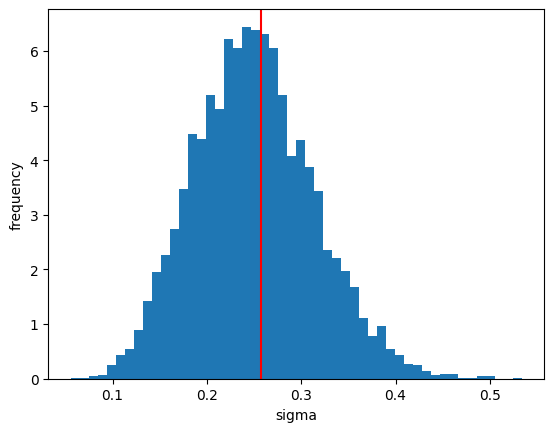

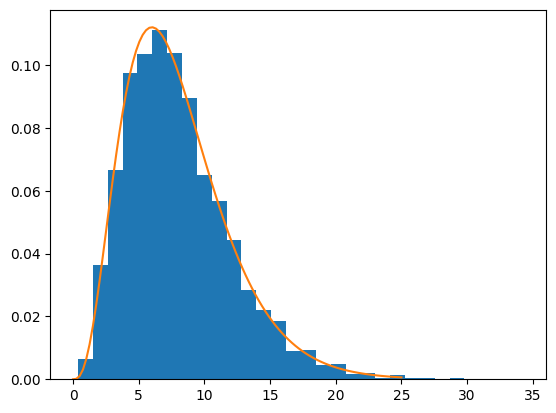

In [7]:
model = linear_model
sigmas_b = []
chi_2_loop = []
#model = non_linear_model # you might add this later
for i in range(0,5000):
    # plot the simulation results
    x_data = np.linspace(xmin, xmax, 10)
    y_data, sigma_y = sim_data(x_data)
    
    popt, pcov = curve_fit(linear_model, x_data, y_data, sigma = sigma_y)
    _, pcov_true = curve_fit(linear_model, x_data, y_data, sigma = sigma_y, absolute_sigma=True)

    sigma_b = np.sqrt(np.diag(pcov))[1]
    sigmas_b.append(sigma_b)
    true_sigma = pcov_true[1,1] #we do [1,1] to get only the sigma_b 
    true_sigma = np.sqrt(true_sigma)

    chi_2_loop.append(np.sum(((y_data - model(x_data, *popt))/sigma_y)**2))


plt.hist(sigmas_b, bins = 50, density=True)
plt.axvline(true_sigma, c='r')
plt.xlabel("sigma")
plt.ylabel("frequency") 
plt.show()

x_value = np.linspace(0, 25, 100)
chi_2 = scipy.stats.chi2.pdf(x_value, 8) 
plt.hist(chi_2_loop, bins = 30, density =True)
plt.plot(x_value, chi_2)
plt.show()

## Part 2: Bootstrap and non-linear least-squares

First let's check that bootstrap works for our linear model. Let's do a non-parametric bootstap:

-  simulate _a single_ dataset with $N=400$ points
- Draw $B=20000$ bootstrap samples.
- Compare the bootstrapped distribution of the parameter $b$ with the normal distribution, $\mathcal{N}(0,\sigma_b)$, predicted by the least-squares fit.

You should find good agreement.

In [19]:
N = 400
data_x = np.linspace(xmin, xmax, N)
data_y, sigma_y = sim_data(data_x)
B = 20000
bootstrap_b = []
bootstrap_sigma_b = []
bootstrap_true_sigma_b = []

for i in range(B):
    indices = np.random.choice(np.arange(0,N), size=N)
    bootstrap = data_y[indices]
    bootstrap_sigma = sigma_y[indices]
    popt, pcov = curve_fit(linear_model, data_x, bootstrap, sigma = bootstrap_sigma)
    popt_true, pcov_true = curve_fit(linear_model, data_x, data_y, sigma = sigma_y, absolute_sigma = True)

    sigma_bootstrap = pcov[1,1]
    chi_bootstrap = np.sum(((data_y - model(data_x, *popt))/sigma_y)**2)

    bootstrap_sigma_b.append(np.sqrt(pcov[1,1]))
    bootstrap_b.append(popt[1])
    bootstrap_true_sigma_b.append(np.sqrt(pcov_true[1,1]))
    

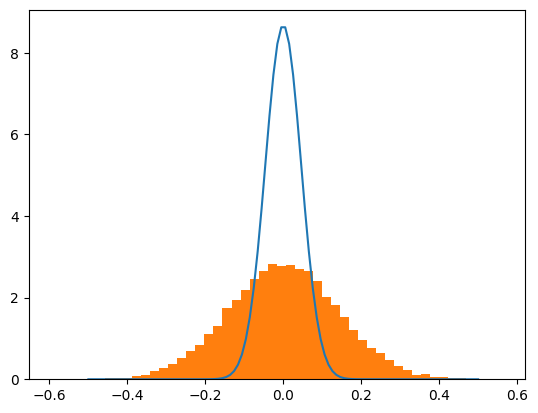

In [20]:
x_values = np.linspace(-0.5, 0.5, 100)
plt.plot(x_values, scipy.stats.norm.pdf(x_values, loc = 0, scale = np.mean(bootstrap_true_sigma_b))) 
plt.hist(bootstrap_b, bins =50, density = True)
plt.show()

The documentation of `curve_fit` says:  
>Note that the relationship between cov and parameter error estimates is derived based on a linear approximation to the model function around the optimum [1]. When this approximation becomes inaccurate, cov may not provide an accurate measure of uncertainty.

But how bad can it be? Let's check. Again we use only two parameters $a$ and $b$.  

We know that the bootstrap will give a more correct answer than least-squares, so we can use this to check the preformance of `curve_fit` confidence intervals.

- dream-up a non-linear model that combines $a$ and $b$, add this above and set `model = non_linear_model`
- Redo comparison of the bootstrap confidence interval with least-squares normal distribution.
 - do you see any difference?
 - Does least-squares aways under/over predict the uncertainty?